In [3]:
from _dfguru import DataFrameGuru as DFG
from _occupancy_forecasting import MasterTrainer, OccFeatureEngineer
from _occupancy_forecasting import load_data
from _evaluating import ParameterSearch

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

import numpy as np
import os
import json
dfg = DFG()
torch.cuda.empty_cache()



In [4]:
n_run = 6
n_param = 0

################################
param_dir = "_occupancy_forecasting/parameters/occrate"
tb_log_dir = "_occupancy_forecasting/training_logs/occrate"
cp_log_dir = "_occupancy_forecasting/checkpoints/occrate"
path_to_data = "data/occupancy_forecasting"

path_to_params = os.path.join(param_dir, f"run-{n_run}-{n_param}_params.json")

parameter_dict = ParameterSearch(path_to_json=path_to_params).parameter_dict

features = parameter_dict["features"][0]
features = set(features.split("_"))

In [5]:
frequency = "15min"
train_dict, val_dict, test_dict = load_data(
    path_to_data, 
    frequency, 
    split_by=parameter_dict["split_by"][0],
    dfguru=dfg,
    with_examweek=parameter_dict["with_examweek"][0]
)

In [6]:
def handle_occ_feature(features):
        if "occcount" in features:
            return "occcount"
        elif "occrate" in features:
            return "occrate"
        elif "occpresence" in features:
            return "occpresence"
        else:
            raise ValueError("No target feature found.")

def handle_time_features(exo_features):
    
    copied_exo_features = exo_features.copy()
    
    if "dow" in copied_exo_features:
        copied_exo_features.remove("dow")
        copied_exo_features = copied_exo_features.union({"dow1", "dow2"})
        
    if "hod" in copied_exo_features:
        copied_exo_features.remove("hod")
        copied_exo_features = copied_exo_features.union({"hod1", "hod2"})
        
    if "week" in copied_exo_features:
        copied_exo_features.remove("week")
        copied_exo_features = copied_exo_features.union({"week1", "week2"})
        
    return copied_exo_features



### 1. Prepare Data

In [7]:
############ Handle Features ############
if "maxocccountestimate" in features:
    raise ValueError("Feature 'maxocccountestimate' is not allowed.")


permissible_features = OccFeatureEngineer.permissible_features


# derive main feature
occ_feature = handle_occ_feature(features)

# derive exogenous features
exogenous_features = permissible_features.difference({"occcount", "occrate"})
# derive exogenous time features
exogenous_features = handle_time_features(exogenous_features)

    
helper_file = os.path.join(path_to_data, "helpers_occpred.json")
with open(helper_file, "r") as f:
    helper = json.load(f)       


if "type" in exogenous_features:
    exogenous_features.remove("type")
    exogenous_features = exogenous_features.union(helper["course_types"])

extract_coursenumber = False
if "coursenumber" in exogenous_features:
    exogenous_features.remove("coursenumber")
    extract_coursenumber = True
    course_numbers = helper["course_numbers"]
    coursenr_lookup = dict([(x,i) for i,x in enumerate(course_numbers)])
    
if "studyarea" in exogenous_features:
    exogenous_features.remove("studyarea")
    exogenous_features = exogenous_features.union(helper["study_areas"])

if "level" in exogenous_features:
    exogenous_features.remove("level")
    exogenous_features = exogenous_features.union(helper["levels"])

if "weather" in exogenous_features:
    exogenous_features.remove("weather")
    exogenous_features = exogenous_features.union(helper["weather_columns"])

# sort features
exogenous_features = sorted(list(exogenous_features))

############ Derive some helper variables ############
include_x_features = parameter_dict["include_x_features"][0]
x_horizon = parameter_dict["x_horizon"][0]
y_horizon = parameter_dict["y_horizon"][0]   


In [8]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.api import ARIMA

from statsmodels.tsa.seasonal import MSTL

In [9]:
room_id = 0
train_set = train_dict[room_id]
test_set = test_dict[room_id]
val_set = val_dict[room_id]

occ_feature_list = [occ_feature, "datetime"]

train_data_endog = train_set[occ_feature_list].set_index("datetime")
train_data_exog = train_set[exogenous_features + ["datetime"]].set_index("datetime")

train_data_endog.index.freq = frequency
train_data_exog.index.freq = frequency


#res = MSTL(train_data_endog, periods=[12*24, 12*24*7]).fit()
#fig = res.plot()
#fig.set_figheight(8)
#fig.set_figwidth(15)
#plt.show()



In [10]:
#fig,ax = plt.subplots(2,1,figsize=(20,10))
#fig = sm.graphics.tsa.plot_acf(train_data_endog.diff(), lags=50, ax=ax[0])
#fig = sm.graphics.tsa.plot_pacf(train_data_endog.diff(), lags=50, ax=ax[1])
#plt.show()

train_data_exog.columns

Index(['Artificial Intelligence', 'B1 - Bachelor 1. Jahr',
       'B2 - Bachelor 2. Jahr', 'B3 - Bachelor 3. Jahr',
       'Betriebswirtschaftslehre', 'Biologische Chemie', 'Chemie',
       'D - Diplom', 'Informatik', 'Informationselektronik', 'KS',
       'Kunststofftechnik', 'M1 - Master 1. Jahr', 'M2 - Master 2. Jahr',
       'Maschinenbau', 'Mathematik', 'Mechatronik', 'Medical Engineering',
       'None_level', 'None_sa', 'Pädagogik', 'Rechtswissenschaften',
       'Sozialwissenschaften', 'Statistik', 'UE', 'VL',
       'Volkswirtschaftslehre', 'Wirtschaftsinformatik', 'cancelled', 'dow1',
       'dow2', 'ects', 'exam', 'ff', 'ffx', 'hod1', 'hod2', 'holiday',
       'lecture', 'lecturerampafter', 'lecturerampbefore', 'maxocccount',
       'maxocccountestimate', 'maxoccrate', 'maxoccrateestimate',
       'occcount1day', 'occcount1week', 'occrate1day', 'occrate1week', 'p',
       'registered', 'rf', 'rr', 'so', 'test', 'tl', 'tutorium', 'week1',
       'week2', 'zwickltag'],
      d

In [19]:
exo_features_to_try = ["lecture", "registered", "exam", "hod1", "hod2", "dow1", "dow2", "week1", "week2"]

model = ARIMA(
    endog=train_data_endog,
    exog=train_data_exog[exo_features_to_try],
    order=(12,1,0)
)
 
 
res = model.fit()   

/home/berni/anaconda3/envs/webapp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                occrate   No. Observations:                 5904
Model:                ARIMA(12, 1, 0)   Log Likelihood               14066.137
Date:                Tue, 19 Nov 2024   AIC                         -28088.275
Time:                        12:26:27   BIC                         -27941.244
Sample:                    04-08-2024   HQIC                        -28037.173
                         - 06-08-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lecture        0.0165      0.002      8.540      0.000       0.013       0.020
registered     0.0001   1.05e-05      9.832      0.000    8.24e-05       0.000
exam          -0.0044      0.002     -2.004      0.045      -0.009   -9.61e-05
hod1          -0.0017      0.009     -0.190      0.849      -0.019       0.016
hod2          -0.0525      0.010     -5.046      0.000      -0.073      -0.032
dow1       -9.763e-05      0.334     -0.000      1.000      -0.654       0.654
dow2       -5.623e-05      0.304     -0.000      1.000      -0.595       0.595
week1         -0.0018     13.363     -0.000      1.000     -26.192      26.188
week2         -0.0021     12.111     -0.000      1.000     -23.738      23.734
ar.L1          0.1271      0.005     24.030      0.000       0.117       0.137
ar.L2         -0.0777      0.011     -7.354      0.000      -0.098      -0.057
ar.L3         -0.1196      0.006    -19.164      0.000      -0.132      -0.107
ar.L4         -0.0750      0.010     -7.247      0.000      -0.095      -0.055
ar.L5         -0.0942      0.009     -9.968      0.000      -0.113      -0.076
ar.L6         -0.2097      0.005    -39.869      0.000      -0.220      -0.199
ar.L7          0.1183      0.006     19.936      0.000       0.107       0.130
ar.L8         -0.1201      0.008    -14.191      0.000      -0.137      -0.104
ar.L9         -0.0769      0.011     -6.905      0.000      -0.099      -0.055
ar.L10        -0.0159      0.013     -1.212      0.226      -0.042       0.010
ar.L11        -0.0289      0.009     -3.097      0.002      -0.047      -0.011
ar.L12        -0.0997      0.009    -11.609      0.000      -0.117      -0.083
sigma2         0.0005    2.6e-06    194.238      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   9.75   Jarque-Bera (JB):            765313.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='datetime'>

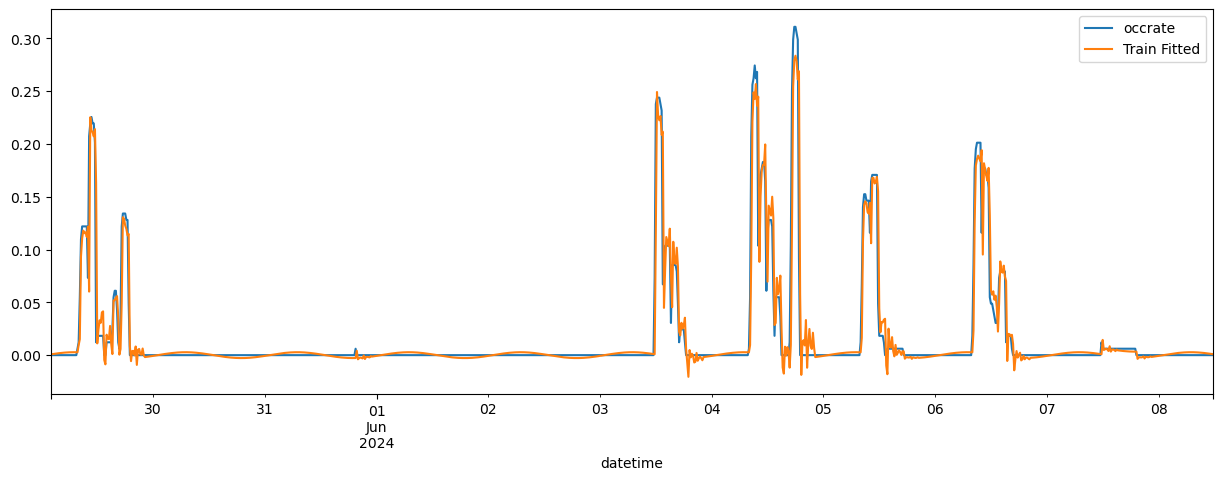

In [21]:
N_last = 1000
train_data_endog[-N_last:].plot(figsize=(15,5), label="Train True", legend=True)
res.fittedvalues[-N_last:].plot(label="Train Fitted", legend=True)

In [ ]:
#val_data_endog = val_set[occ_feature_list].set_index("datetime")
#val_data_exog = val_set[exogenous_features + ["datetime"]].set_index("datetime")

#fig = plt.figure(figsize=(20,8))

#plt.plot(val_data_endog, label="Valset")
#plt.plot(res.forecast(len(val_data_exog), exog=val_data_exog[exo_features_to_try]), label=f"Forecast {0}")
    
#plt.legend(loc='best')
#plt.show()

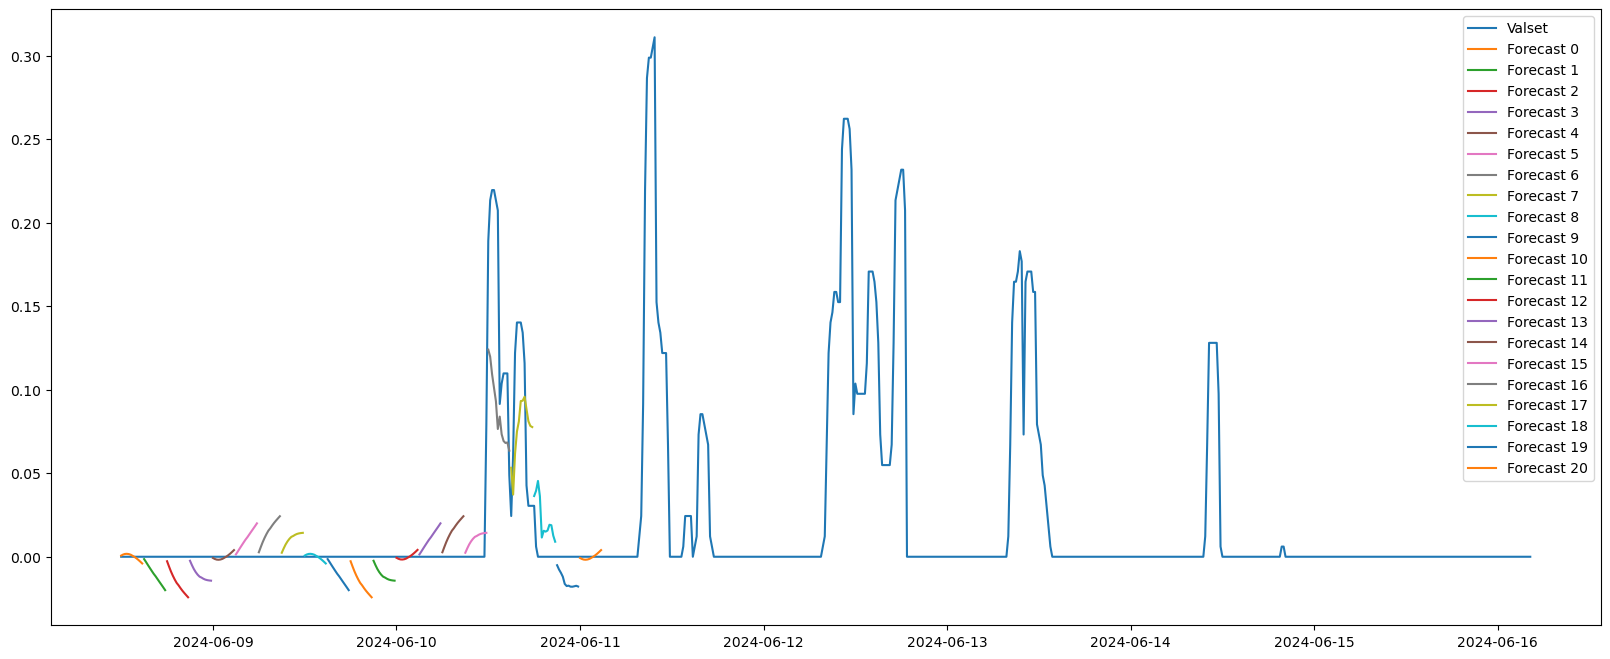

In [22]:
val_data_endog = val_set[occ_feature_list].set_index("datetime")
val_data_exog = val_set[exogenous_features + ["datetime"]].set_index("datetime")[exo_features_to_try]

res_new = res
fig = plt.figure(figsize=(20,8))

plt.plot(val_data_endog, label="Valset")

forecasting_horizon = 12
append_hours = 4 * 3

forecast = res_new.forecast(
    forecasting_horizon, 
    exog=val_data_exog.iloc[:forecasting_horizon]
)

plt.plot(forecast, label=f"Forecast {0}")

for i in range(0, 20):
    
    res_new = res_new.append(
        endog=val_data_endog.iloc[append_hours*i: append_hours*(i+1)],
        exog=val_data_exog.iloc[append_hours*i: append_hours*(i+1)]
        )
    
    forecast = res_new.forecast(
        forecasting_horizon,
        exog=val_data_exog.iloc[append_hours*(i+1): append_hours*(i+1)+forecasting_horizon]
    )
    
    plt.plot(
        forecast,
        label=f"Forecast {i+1}"
    )
    
plt.legend(loc='best')
plt.show()

In [23]:
i = 6
res_new = res_new.append(val_data_endog.iloc[288*i:288*(i+1)])

fig = plt.figure(figsize=(20,8))

plt.plot(val_data_endog, label="Valset")

plt.plot(res_new.forecast(288), label="Forecast")
plt.legend(loc='best')
plt.show()

ValueError: Prediction must have `end` after `start`.

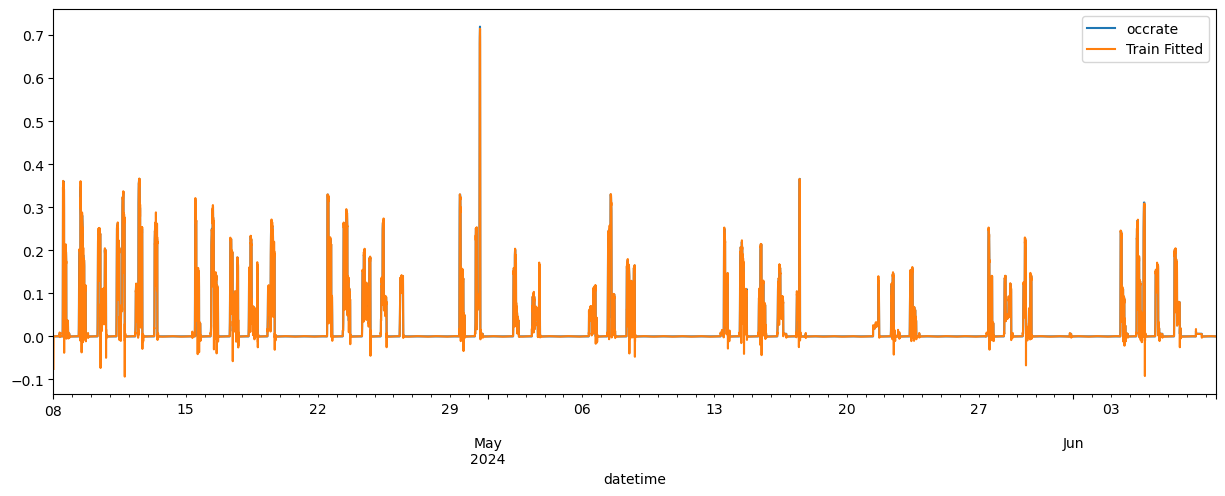

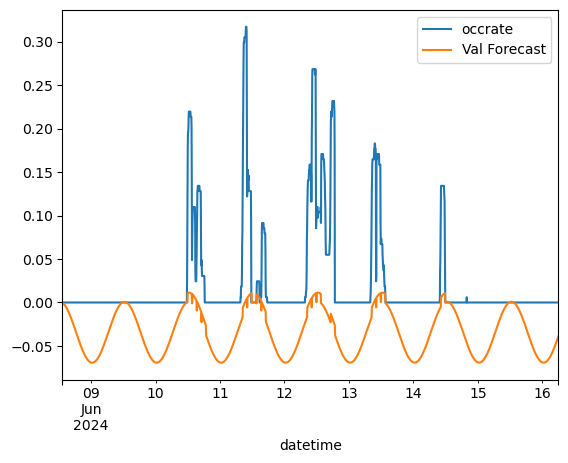

In [162]:
# plot train data
train_data_endog.plot(figsize=(15,5), label="Train True", legend=True)
res.fittedvalues.plot(label="Train Fitted", legend=True)


# forecast and plot
val_data = val_dict[room_id]
val_data_endog = val_data[occ_feature_list].set_index("datetime")
val_data_exog = val_data[exogenous_features + ["datetime"]].set_index("datetime")
forecasts = res.forecast(steps=len(val_data), exog=val_data_exog[exo_features_to_try])

# plot results
val_data_endog.plot(label="Val True", legend=True)
forecasts.plot(label="Val Forecast", legend=True)

plt.show()

In [131]:

fig = plt.figure(figsize=(12,8))

,occrate
datetime,
2024-04-08 00:00:00,0.0
2024-04-08 00:05:00,0.0
2024-04-08 00:10:00,0.0
2024-04-08 00:15:00,0.0
2024-04-08 00:20:00,0.0
...,...
2024-06-08 12:55:00,0.0
2024-06-08 13:00:00,0.0
2024-06-08 13:05:00,0.0


<Figure size 1200x800 with 0 Axes>